In [47]:
#%pip install yfinance
#%pip install matplotlib
#%pip install statsmodels 
#%pip install -U scikit-learn
#%pip install seaborn
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns



Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 294 kB 7.1 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
Apple = yf.download("AAPL").reset_index()
Apple

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099058,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093890,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086999,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089152,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091737,73449600
...,...,...,...,...,...,...,...
10951,2024-05-22,192.270004,192.820007,190.270004,190.899994,190.899994,34648500
10952,2024-05-23,190.979996,191.000000,186.630005,186.880005,186.880005,51005900
10953,2024-05-24,188.820007,190.580002,188.039993,189.979996,189.979996,36294600
10954,2024-05-28,191.509995,193.000000,189.100006,189.990005,189.990005,52280100


In [6]:
df = pd.read_csv('Apple Product Timeline.csv')
df['Released'].ffill(inplace=True)
df = df.loc[df['Released'].str[0].str.isdigit()]
df['Released'] = pd.to_datetime(df['Released'])
# operations on the data to clean up the file, remove irrelevant rows and columns
df

/var/folders/hw/yxwyz93n6bnfmq75trqppqqr0000gn/T/ipykernel_72050/2749935952.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Released'].ffill(inplace=True)
/var/folders/hw/yxwyz93n6bnfmq75trqppqqr0000gn/T/ipykernel_72050/2749935952.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Released'] = pd.to_datetime(df['Released'])


,Released,Model,Family,Discontinued
0,1976-04-11,Apple I,Apple I,30-Sep-77
1,1977-06-01,Apple II,Apple II,1-May-79
2,1978-06-01,Disk II,Drives,1-May-84
3,1979-06-01,Apple II Plus,Apple II series,1-Dec-82
4,1979-06-01,Apple II EuroPlus,NaN,1-Dec-82
...,...,...,...,...
760,2024-05-15,iPad Air 11-in (M2),iPad,current
761,2024-05-15,iPad Air 13-in (M2),iPad,current
762,2024-05-15,iPad Pro 11-in. (M4),iPad,current
763,2024-05-15,iPad Pro 13-in. (M4),iPad,current


stock movements -> product launch
for example, observe whether a low point in apple stock prices push product launch schedule forward (say on average product launches are spaced out by x, a downward trend/local min would shorten this time/land on the shorter end of the timeline)
Vice versa, if high stock prices will drive investment into RND which in turn gives faster launches or more innovative products?


In [116]:
# aggregate product launches by date, compare with the timeline of stocks data, observe whether a high/low movement
# of stock result in more/less releases
# Then aggregate by month/year, observe overall launches against stock movement
launches = df[['Released', 'Model']].groupby('Released').count()
# operations on the data to clean up the file, remove irrelevant rows and columns
launches
# Convert the stock price date to datetime
Apple['Date'] = pd.to_datetime(Apple['Date'])

# Merge the dataframes on the date
merged_data = pd.merge(launches, Apple, left_on='Released', right_on='Date', how='right')

# Fill NaN values in launch_count with 0
merged_data['Model'] = merged_data['Model'].fillna(0)
print(merged_data.head())

   Model       Date      Open      High       Low     Close  Adj Close  \
0    0.0 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.099058   
1    0.0 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093890   
2    0.0 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086999   
3    0.0 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089152   
4    0.0 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091737   

      Volume  
0  469033600  
1  175884800  
2  105728000  
3   86441600  
4   73449600  


In [117]:
# Calculate daily stock price movement
merged_data['price_movement'] = merged_data['Close'].pct_change()
merged_data['price_movement'] = merged_data['price_movement'].fillna(0)

# Calculate the correlation
correlation = merged_data['Model'].corr(merged_data['price_movement'])

print(f"Correlation between product launches and stock price movement: {correlation}")

Correlation between product launches and stock price movement: -0.006723710919164765


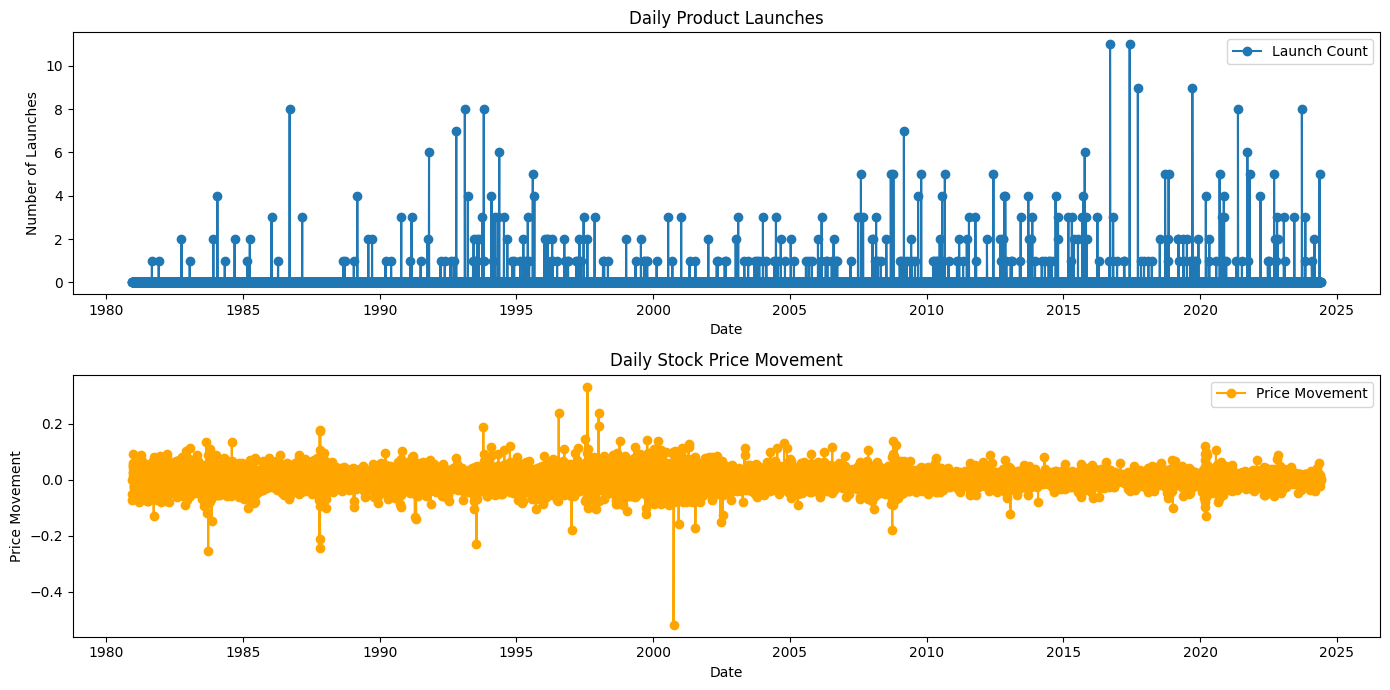

In [118]:
import matplotlib.pyplot as plt

# Plot daily product launches
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(merged_data['Date'], merged_data['Model'], marker='o', linestyle='-', label='Launch Count')
plt.title('Daily Product Launches')
plt.xlabel('Date')
plt.ylabel('Number of Launches')
plt.legend()

# Plot daily stock price movement
plt.subplot(2, 1, 2)
plt.plot(merged_data['Date'], merged_data['price_movement'], marker='o', linestyle='-', color='orange', label='Price Movement')
plt.title('Daily Stock Price Movement')
plt.xlabel('Date')
plt.ylabel('Price Movement')
plt.legend()

plt.tight_layout()
plt.show()


In [123]:
# Do a relationship analysis/linear regression model to analyze trend & a potential causal relationship
# Define the independent (X) and dependent (y) variables
X = merged_data[['price_movement']]
y = merged_data['Model']

# Add a constant to the independent variable matrix for the intercept term
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Model   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4952
Date:                Sun, 02 Jun 2024   Prob (F-statistic):              0.482
Time:                        17:05:34   Log-Likelihood:                -6736.8
No. Observations:               10956   AIC:                         1.348e+04
Df Residuals:                   10954   BIC:                         1.349e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0556      0.004     12.

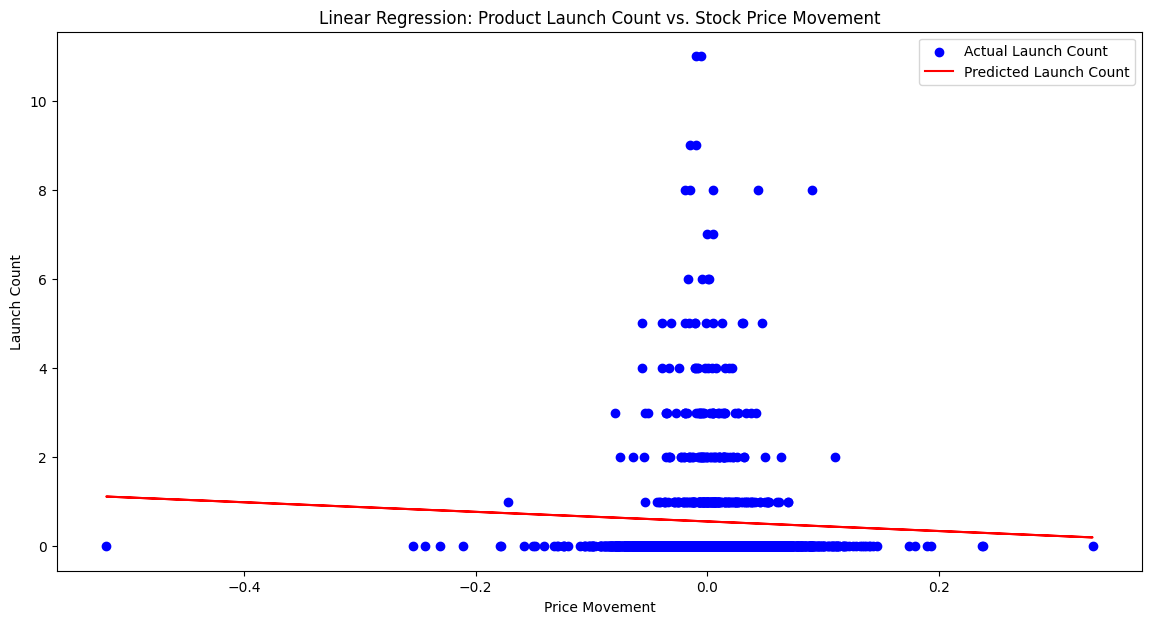

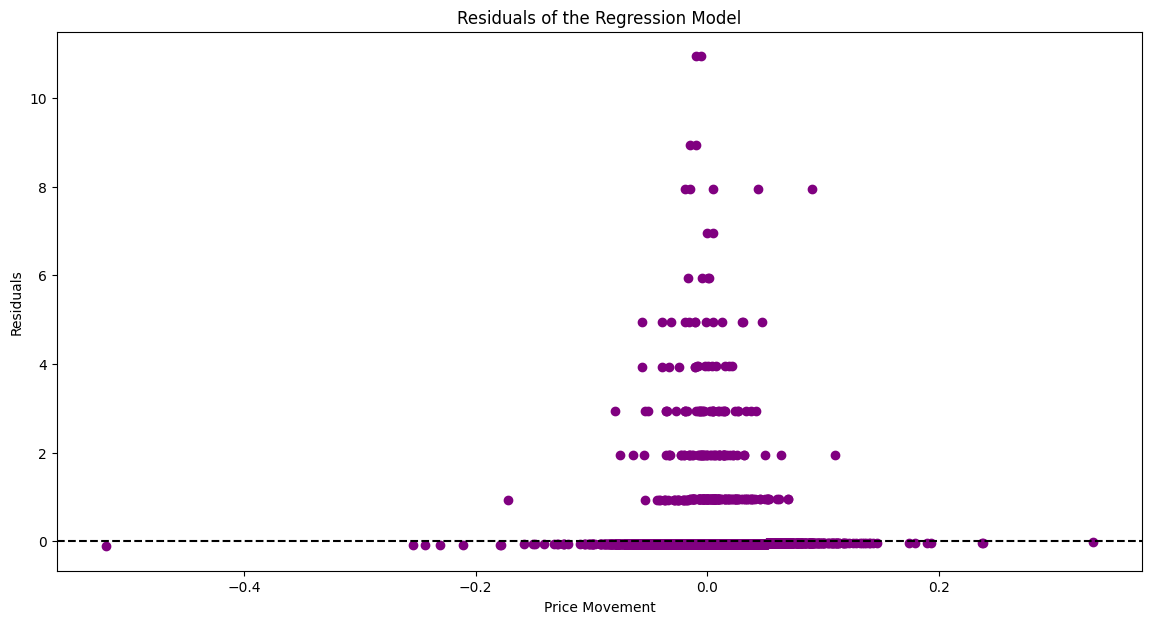

In [125]:
# Predict the launch count using the model
merged_data['predicted_launch_count'] = model.predict(X)*10

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.scatter(merged_data['price_movement'], merged_data['Model'], color='blue', label='Actual Launch Count')
plt.plot(merged_data['price_movement'], merged_data['predicted_launch_count'], color='red', label='Predicted Launch Count')
plt.xlabel('Price Movement')
plt.ylabel('Launch Count')
plt.title('Linear Regression: Product Launch Count vs. Stock Price Movement')
plt.legend()
plt.show()

# Plot the residuals
plt.figure(figsize=(14, 7))
plt.scatter(merged_data['price_movement'], model.resid, color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Price Movement')
plt.ylabel('Residuals')
plt.title('Residuals of the Regression Model')
plt.show()

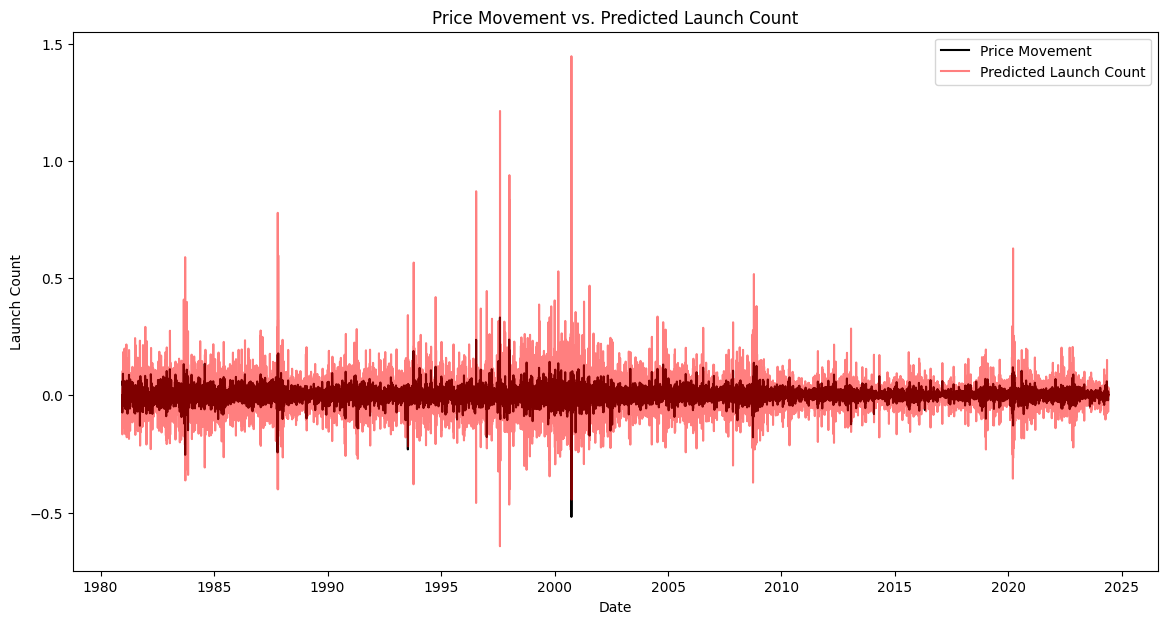

In [107]:
# Plot the predicted value against 
plt.figure(figsize=(14, 7))

# Scatter plot of price movements
plt.plot(merged_data['Date'], merged_data['price_movement'], color='black', label='Price Movement')

# Line plot of predicted launch counts
plt.plot(merged_data['Date'], merged_data['predicted_launch_count'].pct_change(), color='red', label='Predicted Launch Count', alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Launch Count')
plt.title('Price Movement vs. Predicted Launch Count')
plt.legend()
plt.show()



In [129]:
# compute an average timeframe between product launches, and check the variance on the data plotted against stock trends
# would downward trend rush launches?
# would upward trend lay back launches? 
# would high stock prices up investment into R&D, thus improving launch speed?

# Ensure the product launches are sorted by date
product_launches = df.sort_values(by='Released')

# Calculate the time differences between consecutive launches
product_launches['time_diff'] = product_launches['Released'].diff().dt.days

# Drop the first row as it will have NaN time_diff
product_launches = product_launches.dropna()

# Calculate the average and variance of the time differences
average_time_diff = product_launches['time_diff'].mean()
variance_time_diff = product_launches['time_diff'].var()

print(f'Average time between product launches: {average_time_diff:.2f} days')
print(f'Variance of time between product launches: {variance_time_diff:.2f} days^2')


Average time between product launches: 25.98 days
Variance of time between product launches: 2873.85 days^2


In [130]:
# Calculate the stock movement leading up to each launch date
launch_dates = product_launches['Released']

# Define a function to calculate stock trends before each launch date
def stock_trend_before_launch(date, window=5):
    subset = Apple[(Apple['Date'] <= date) & (Apple['Date'] > date - pd.Timedelta(days=window))]
    if len(subset) > 0:
        return (subset['Close'] - subset['Open']).mean()
    return 0

# Apply the function to each launch date
product_launches['avg_stock_movement_before_launch'] = product_launches['Released'].apply(stock_trend_before_launch)

# Examine the correlation between average stock movement and time difference between launches
correlation = product_launches['avg_stock_movement_before_launch'].corr(product_launches['time_diff'])
print(f'Correlation between stock movement before launch and time between launches: {correlation:.2f}')


Correlation between stock movement before launch and time between launches: 0.02


In [131]:
# Calculate the average stock price leading up to each launch date
def avg_stock_price_before_launch(date, window=5):
    subset = Apple[(Apple['Date'] <= date) & (Apple['Date'] > date - pd.Timedelta(days=window))]
    if len(subset) > 0:
        return subset['Close'].mean()
    return 0

# Apply the function to each launch date
product_launches['avg_stock_price_before_launch'] = product_launches['Released'].apply(avg_stock_price_before_launch)

# Examine the correlation between average stock price before launch and time difference between launches
correlation_price = product_launches['avg_stock_price_before_launch'].corr(product_launches['time_diff'])
print(f'Correlation between stock price before launch and time between launches: {correlation_price:.2f}')


Correlation between stock price before launch and time between launches: -0.10


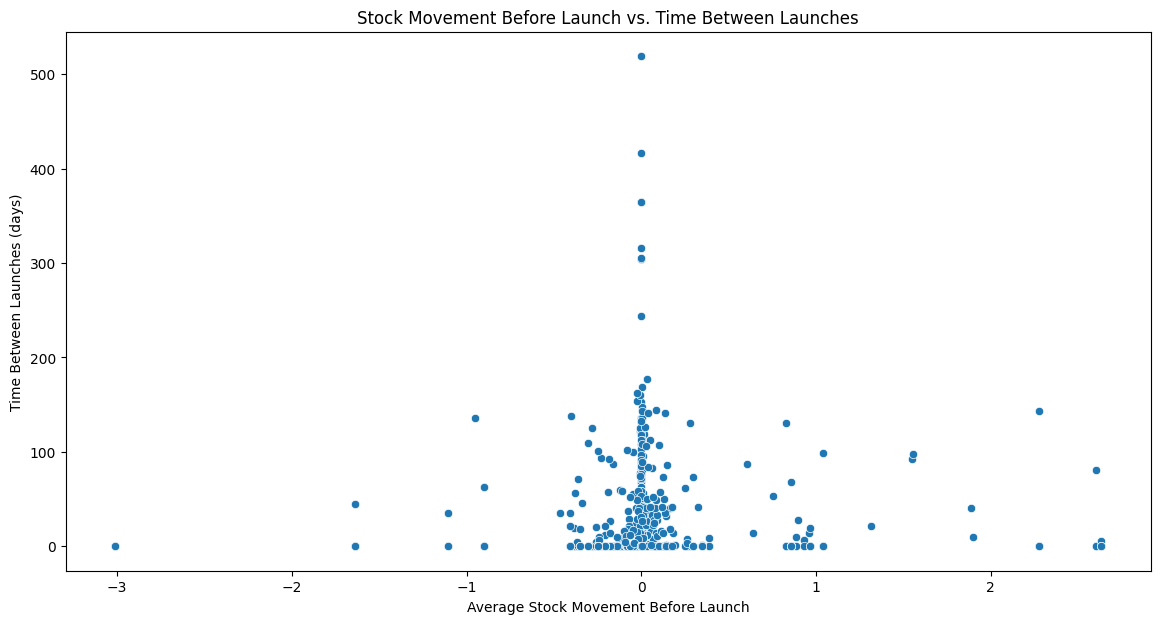

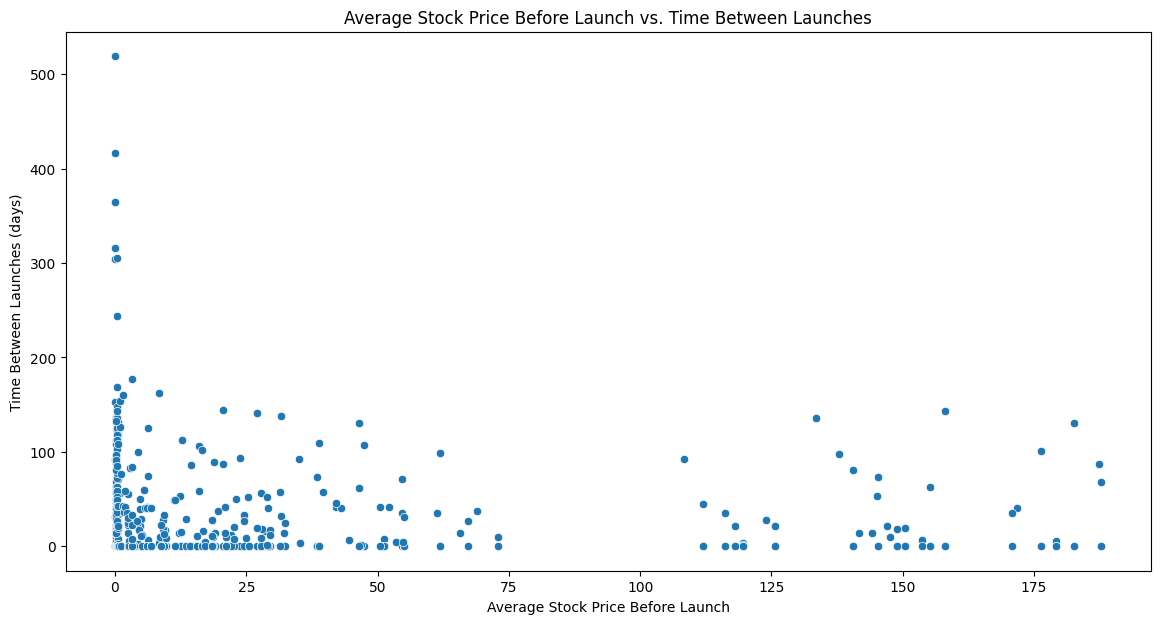

In [138]:
# Plot stock movement before launch vs time between launches
plt.figure(figsize=(14, 7))
sns.scatterplot(x='avg_stock_movement_before_launch', y='time_diff', data=product_launches)
plt.xlabel('Average Stock Movement Before Launch')
plt.ylabel('Time Between Launches (days)')
plt.title('Stock Movement Before Launch vs. Time Between Launches')
plt.show()

# Plot average stock price before launch vs time between launches
plt.figure(figsize=(14, 7))
sns.scatterplot(x='avg_stock_price_before_launch', y='time_diff', data=product_launches)
plt.xlabel('Average Stock Price Before Launch')
plt.ylabel('Time Between Launches (days)')
plt.title('Average Stock Price Before Launch vs. Time Between Launches')
plt.show()

In [141]:
# Predictive model: likelihood of product launches given stock trends!
# Create labels: 1 if there was a launch, 0 otherwise
merged_data['label'] = merged_data['Model'].apply(lambda x: 1 if x > 0 else 0)

# Select features (stock trends) and labels
X = merged_data[['price_movement']]
y = merged_data['label']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [142]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict labels for the testing set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

# Confusion matrix
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2139
           1       0.00      0.00      0.00        53

    accuracy                           0.98      2192
   macro avg       0.49      0.50      0.49      2192
weighted avg       0.95      0.98      0.96      2192


Confusion Matrix:
[[2139    0]
 [  53    0]]


/Users/jerrychen/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jerrychen/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jerrychen/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [151]:
# Predict the likelihood of product launches (1) given stock trends
# Example: predict_proba() for a stock trend
likelihood_of_launch = model.predict_proba([[-300]])[0][1]
print(f'Likelihood of product launch: {likelihood_of_launch:.2f}')

Likelihood of product launch: 0.22


/Users/jerrychen/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
